In [1]:
%load_ext autoreload
%autoreload 2

# Evaluation on Binarized MNIST

In this notebook, we evaluate the trained model on Binarized MNIST dataset. We calculate the FID score and NLL on the test set.

In [2]:
import os
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from easydict import EasyDict
from matplotlib import pyplot as plt
import numpy as np

from models import get_flow_model
from datasets import get_dataset
from evaluation.fid import get_fid, calculate_activation_statistics, InceptionV3

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
ckpt_path = 'logs/bmnist_ot/100000.pt'
print(f'Loading checkpoint from {ckpt_path}...')
ckpt = torch.load(ckpt_path, map_location='cpu')
print('Checkpoint loading complete!')
config = EasyDict(ckpt['config'])
print(config)
print('Loading model...')
model = get_flow_model(config.model, config.encoder).to(device)
model.load_state_dict(ckpt['model'])
model.eval()
print('Model loading complete!')

Loading checkpoint from logs/bmnist_ot/100000.pt...
Checkpoint loading complete!
{'train': {'seed': 42, 'max_iter': 100000, 'batch_size': 256, 'log_freq': 50, 'val_freq': 500, 'save_freq': 5000, 'max_grad_norm': 100.0, 'optimizer': {'type': 'adam', 'lr': 0.0003, 'weight_decay': 0.0, 'beta1': 0.9, 'beta2': 0.999}, 'scheduler': {'type': 'plateau', 'factor': 0.5, 'patience': 10, 'min_lr': 0.0001}}, 'datasets': {'type': 'bmnist', 'root': './data/bmnist'}, 'model': {'type': 'sphere', 'data_dims': [28, 28], 'n_class': 2, 'ot': True}, 'encoder': {'type': 'cnn'}, 'conditioned': False, 'visualizer': {'type': 'bmnist', 'n_sample': 100, 'n_step': 200}}
Loading model...
Model loading complete!


In [4]:
train_set, valid_set, test_set = get_dataset(config.datasets)
train_loader = DataLoader(train_set, batch_size=512)

## Precompute FID statistics

If you have already computed the FID statistics and stored them at `bmnist_fid.npz`, you can skip this cell.

In [5]:
gt = []
for samples, *_ in tqdm(train_loader):
    img = (samples[..., 0] > samples[..., 1]).float().view(-1, 1, 28, 28).expand(-1, 3, -1, -1)
    gt.append(img)
gt = torch.cat(gt, dim=0)
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception = InceptionV3([block_idx]).to(device)
inception.eval()
mu, sigma = calculate_activation_statistics(gt, inception, device, batch_size=256)
np.savez('bmnist_fid.npz', mu=mu, sigma=sigma)
print('Done! Statistics saved to bmnist_fid.npz')

100%|██████████| 98/98 [00:04<00:00, 23.90it/s]


Done! Statistics saved to bmnist_fid.npz


## Calculate FID

FID calculation can take more than 1 minute. The `get_fid` function automatically loads the precomputed statistics from `bmnist_fid.npz`.

100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


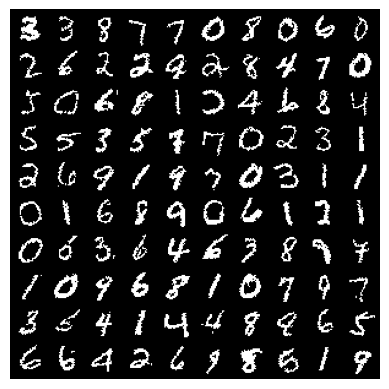

In [6]:
samples = []
model.eval()
total_sample = 1000
batch_size = 100
n_batch = total_sample // batch_size
with torch.no_grad():
    for _ in tqdm(range(n_batch)):
        s = model.sample('ode', n_sample=batch_size, n_steps=300, device=device)
        samples.append(s.detach().cpu())
    samples = torch.cat(samples)
    img = (samples[..., 0] > samples[..., 1]).float().view(-1, 1, 28, 28).expand(-1, 3, -1, -1)
plt.imshow(make_grid(img[:100], nrow=10, padding=2, pad_value=0).permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()

In [7]:
fid = get_fid(img, device, batch_size=256)
print(f'FID: {fid:.4f}')

FID: 4.5160


## Calculate NLL

NLL calculation with the Dopri5 ODE solver can take long. You can switch to `method='euler'` for a faster (but less accurate) calculation.

In [8]:
def cal_elbo(model, dataset, max_sample=1000, batch_size=100, method='ode', n_step=500, tmax=0.995):
    generator = torch.Generator()
    generator.manual_seed(42)
    idx = torch.randperm(len(dataset), generator=generator)[:max_sample]
    subset = [dataset[i][0] for i in idx]

    nlls = []
    model.eval()
    with torch.no_grad():
        for i in range(0, max_sample, batch_size):
            x = torch.stack(subset[i:i + batch_size], dim=0).to(device)
            nll = model.compute_elbo(method, x.to(device), n_step, tmax=tmax, verbose=True)
            nlls.append(nll.item())
            print(f'NLL: {sum(nlls) / len(nlls):.4f}')
    nlls = np.array(nlls)
    print(f'Avg NLL: {nlls.mean():.4f} ± {nlls.std():.4f}')

In [9]:
cal_elbo(model, test_set, max_sample=1000, batch_size=100, method='ode', n_step=300, tmax=0.995)

logp0: 0.0000, logdetjac: 5.1392, logt0: -0.6250, logt1: 2.4544
nll: -6.9686, logx: -0.0025, logq: 5.2983
NLL: -1.6677
logp0: 0.0000, logdetjac: 5.1367, logt0: -0.6212, logt1: 2.4564
nll: -6.9719, logx: -0.0025, logq: 5.2983
NLL: -1.6694
logp0: 0.0000, logdetjac: 5.1358, logt0: -0.6235, logt1: 2.4597
nll: -6.9721, logx: -0.0025, logq: 5.2983
NLL: -1.6700
logp0: 0.0000, logdetjac: 5.1456, logt0: -0.6215, logt1: 2.4599
nll: -6.9839, logx: -0.0025, logq: 5.2983
NLL: -1.6733
logp0: 0.0000, logdetjac: 5.1388, logt0: -0.6179, logt1: 2.4569
nll: -6.9778, logx: -0.0025, logq: 5.2983
NLL: -1.6740
logp0: 0.0000, logdetjac: 5.1735, logt0: -0.6299, logt1: 2.4595
nll: -7.0031, logx: -0.0025, logq: 5.2983
NLL: -1.6787
logp0: 0.0000, logdetjac: 5.1447, logt0: -0.6263, logt1: 2.4578
nll: -6.9762, logx: -0.0025, logq: 5.2983
NLL: -1.6783
logp0: 0.0000, logdetjac: 5.1495, logt0: -0.6208, logt1: 2.4601
nll: -6.9887, logx: -0.0025, logq: 5.2983
NLL: -1.6795
logp0: 0.0000, logdetjac: 5.1696, logt0: -0.6192